In [1]:
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Setup Paths
models_dir = Path("models")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cpu


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(x, [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden], dim=-1)

class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T
        # These parameter names match your saved training file exactly
        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        """
        Symmetrized Free Energy (Matches your training logic).
        """
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        # 1. State v
        linear_v = v_W + c_mod
        term2_v = F.softplus(linear_v).sum(dim=-1)
        term1_v = -(v * b_mod).sum(dim=-1)
        fe_v = term1_v - term2_v

        # 2. State 1-v
        linear_flip = W_sum.unsqueeze(0) - v_W + c_mod
        term2_f = F.softplus(linear_flip).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)
        fe_flipped = term1_f - term2_f

        # Combine
        stacked = torch.stack([-fe_v, -fe_flipped], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        return torch.bernoulli(p_v, generator=rng)

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        """
        FIXED: Returns 0.5 * log(P(v)) = log(Psi(v)).
        This is required for the Swap Test to work correctly.
        """
        b_mod, c_mod = self._compute_effective_biases(cond)
        # log(P) = -FE/T
        # log(Psi) = 0.5 * log(P) = -0.5 * FE / T
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.view(-1, 1)
        cond = cond.to(self.W.device, dtype=self.W.dtype)
        b_mod, c_mod = self._compute_effective_biases(cond)
        B = cond.shape[0]
        v = (torch.rand((B, self.num_visible), generator=rng, device=cond.device) < 0.5).float()

        if T_schedule.dim() == 0: T_schedule = T_schedule.view(1)
        for i in range(int(T_schedule.shape[0])):
            v = self._gibbs_step(v, b_mod, c_mod, float(T_schedule[i]), rng)
        return v

In [3]:
def compute_renyi_entropy(samples: torch.Tensor, subs_size: int,
                          log_score_fn: callable) -> float:
    n_samples = samples.shape[0]
    half = n_samples // 2
    if half == 0: return 0.0

    ref_1 = samples[:half]
    ref_2 = samples[half:2 * half]

    ref_1_score = log_score_fn(ref_1)
    ref_2_score = log_score_fn(ref_2)

    slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)

    # Create Swapped Replicas
    swap_1 = ref_1.clone()
    swap_1[:, slice_idx] = ref_2[:, slice_idx]
    swap_2 = ref_2.clone()
    swap_2[:, slice_idx] = ref_1[:, slice_idx]

    swap_1_score = log_score_fn(swap_1)
    swap_2_score = log_score_fn(swap_2)

    # Ratio of Amplitudes (because log_score returns log(Psi))
    log_swap_ratio = (swap_1_score + swap_2_score) - (ref_1_score + ref_2_score)
    swap_exp = torch.exp(log_swap_ratio).mean().item()

    if swap_exp <= 1e-12: return 0.0
    return -math.log(swap_exp)

def load_checkpoint(filename):
    path = models_dir / filename
    print(f"Loading: {path}")
    checkpoint = torch.load(path, map_location=device)
    cfg = checkpoint["config"]

    model = ConditionalRBM(
        num_visible=cfg["num_visible"],
        num_hidden=cfg["num_hidden"],
        cond_dim=cfg.get("cond_dim", 1),
        conditioner_width=cfg.get("conditioner_width", 64),
        k=cfg.get("k_steps", 30)
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, cfg

In [4]:
# --- UPDATE FILENAME HERE ---
filename = "crbm_tfim_16_20000_20251211_192438.pt"

model, config = load_checkpoint(filename)

CHAIN_LENGTH = config["system_size"]
h_support_vals = sorted(config["h_support"])

print(f"Model Loaded. System Size: {CHAIN_LENGTH}")
print(f"Support Points: {h_support_vals}")

Loading: models/crbm_tfim_16_20000_20251211_192438.pt
Model Loaded. System Size: 16
Support Points: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]


In [5]:
# --- EVALUATION CONFIG ---
dense_resolution = 0.05
eval_samples = 20_000
eval_steps = 300
T_eval = 1.0

# 1. Prepare h grid
h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, dense_resolution)
h_novel_vals = np.array([h for h in h_novel_vals if not any(np.isclose(h, s, atol=1e-3) for s in h_support_vals)])
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

results_list = []
l_axis = list(range(1, CHAIN_LENGTH // 2 + 1))
rng_eval = torch.Generator(device=device).manual_seed(1234)
model_dtype = next(model.parameters()).dtype

print(f"=== GENERATING ENTROPY DATA ===")
print(f"Total points: {len(all_h_values)}")

for i, h_val in enumerate(all_h_values):
    pt_type = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "interpolated"

    # A. Generate Samples
    cond_gen = torch.tensor([[h_val]], device=device, dtype=model_dtype).expand(eval_samples, -1)
    T_schedule = torch.full((eval_steps,), T_eval, device=device, dtype=model_dtype)

    with torch.no_grad():
        samples = model.generate(cond_gen, T_schedule, rng_eval)

    # B. Define Scorer
    # (No manual 0.5 mult needed here, it's inside the model class now)
    cond_score = torch.tensor([[h_val]], device=device, dtype=model_dtype)
    scorer = lambda v: model.log_score(v, cond_score)

    # C. Compute Entropy
    for l in l_axis:
        s2 = compute_renyi_entropy(samples, l, scorer)
        results_list.append({"h": float(h_val), "l": int(l), "s2": float(s2), "type": pt_type})

    if (i+1) % 5 == 0 or (i+1) == len(all_h_values):
        print(f"[{i+1}/{len(all_h_values)}] h={h_val:.3f} ({pt_type})")

df_res = pd.DataFrame(results_list)
print("Evaluation Complete.")

=== GENERATING ENTROPY DATA ===
Total points: 21
[5/21] h=0.700 (interpolated)
[10/21] h=0.950 (support)
[15/21] h=1.200 (support)
[20/21] h=1.450 (interpolated)
[21/21] h=1.500 (support)
Evaluation Complete.


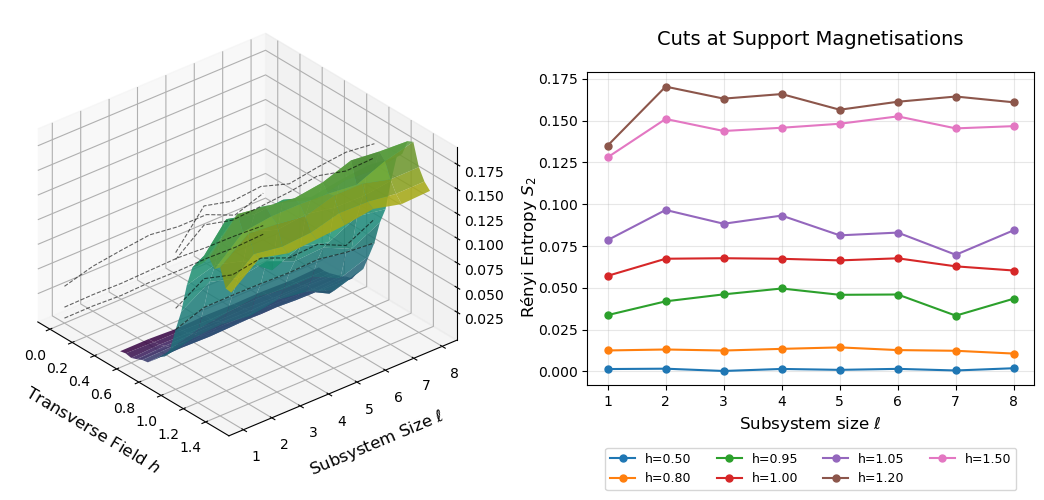

In [6]:
# --- PLOTTING CONFIG ---
PLOT_WSPACE = -0.15
VERTICAL_OFFSET_2D = 0.02
BOX_ASPECT_2D = 0.7
Z_LABEL_PAD = 9
TITLE_PAD_2D = 20
LEGEND_NCOL = 4
LEGEND_X = 0.5
LEGEND_Y = -0.18

fig = plt.figure(figsize=(16, 6))
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# Pivot Data for 3D Surface
pivot_df = df_res.pivot(index='l', columns='h', values='s2')
h_dense = pivot_df.columns.values
l_values = pivot_df.index.values
X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.values

# === 3D PLOT ===
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho')
cmap_surface = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=h_dense.min(), vmax=h_dense.max())
surface_colors = cmap_surface(norm(X_h))

ax3d.plot_surface(X_h, Y_l, Z_s2, facecolors=surface_colors, rstride=1, cstride=1,
                  shade=True, linewidth=0, alpha=0.85, antialiased=True)

ax3d.set_xlabel('Transverse Field $h$', fontsize=12, labelpad=10)
ax3d.set_ylabel('Subsystem Size $\\ell$', fontsize=12, labelpad=10)
ax3d.set_zlabel(r'Rényi Entropy $S_2$', fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)

# === 2D PLOT ===
ax2d = fig.add_subplot(gs[1])
ax2d.set_box_aspect(BOX_ASPECT_2D)
pos = ax2d.get_position()
ax2d.set_position([pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height])

cmap_2d_cycle = plt.get_cmap("tab10")
support_h_keys = df_res[df_res['type'] == 'support']['h'].unique()
support_h_keys.sort()

for i, h in enumerate(support_h_keys):
    s2_vals = df_res[df_res['h'] == h].sort_values('l')['s2'].values
    line_color = cmap_2d_cycle(i % 10)

    # Add Dashed lines to 3D plot
    ax3d.plot(np.full_like(l_values, h), l_values, s2_vals, color='black',
              linestyle='--', linewidth=0.8, alpha=0.6, zorder=10)

    # Add lines to 2D plot
    ax2d.plot(l_values, s2_vals, marker='o', linestyle='-', color=line_color,
              markersize=5, label=f"h={h:.2f}")

ax2d.set_xlabel("Subsystem size $\\ell$", fontsize=12)
ax2d.set_title("Cuts at Support Magnetisations", fontsize=14, pad=TITLE_PAD_2D)
ax2d.legend(frameon=True, fontsize=9, loc='upper center', bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, alpha=0.3)
plt.show()